In [8]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from skimage.color import rgb2lab, lab2rgb

In [9]:

class CocoColorizationDataset(Dataset):
    """
        L: [1, H, W]   ([0,1])
        ab: [2, H, W]  ([-1,1])
    """
    def __init__(self, 
                 root_dir="data/coco/train2017", 
                 transform_size=128, 
                 limit=5000):
        super().__init__()
        self.root_dir = root_dir

        valid_extensions = {".jpg", ".jpeg", ".png"}
        self.files = [fname for fname in sorted(os.listdir(root_dir))
                      if os.path.splitext(fname)[1].lower() in valid_extensions]
        
        self.files = self.files[:limit]

        self.transform = T.Compose([
            T.Resize((transform_size + 20, transform_size + 20)),
            T.RandomCrop((transform_size, transform_size)),
            T.RandomHorizontalFlip(),
        ])
        
        print(f"Found {len(self.files)} valid images in {self.root_dir}")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        try:
            fname = self.files[idx]
            img_path = os.path.join(self.root_dir, fname)
            img = Image.open(img_path).convert("RGB")
            img = self.transform(img)
            img_np = np.array(img).astype(np.float32) / 255.0
            lab = rgb2lab(img_np)
            L = lab[:, :, 0]    # L [0, 100]
            ab = lab[:, :, 1:3] # ab [-128, 127]
            L = L / 100.0      # [0, 1]
            ab = ab / 128.0    # [-1, 1]
            # [C, H, W]
            L = torch.from_numpy(L).unsqueeze(0)           # [1, H, W]
            ab = torch.from_numpy(ab).permute(2, 0, 1)       # [2, H, W]
            return L, ab
        except Exception as e:
            print(f"Error loading image {fname}: {e}")
            raise e


In [10]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


# (DoubleConv + MaxPool) => output (skip, pooled)
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.double_conv(x)
        x_down = self.pool(x)
        return x, x_down


class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up_transpose = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = DoubleConv(out_channels*2, out_channels)

    def forward(self, x, skip):
        """
        x: features from previous layer
        skip: with Down output(before pool)
        """
        x = self.up_transpose(x)  # upsampling => [B, out_channels, H*2, W*2]
        x = torch.cat([skip, x], dim=1)   # skip_channels + out_channels
        x = self.conv(x)
        return x


#    input: in_channels=4 (L 1 + clickmap 1 + color (a,b) 2)
#    output: out_channels=2 (a, b)
class UNetColorNet(nn.Module):
    def __init__(self, in_channels=4, out_channels=2):
        """
         down1: 4  -> 64
         down2: 64 -> 128
         down3: 128-> 256
         down4: 256-> 512
         bottleneck: 512->1024
         up1: 1024->512 + skip(512) => conv=512
         up2: 512->256 + skip(256) => conv=256
         up3: 256->128 + skip(128) => conv=128
         up4: 128->64  + skip(64)  => conv=64
         final: 64 -> 2  (ab)
        """
        super(UNetColorNet, self).__init__()
        
        self.down1 = Down(in_channels, 64)   # 4 -> 64
        self.down2 = Down(64, 128)           # 64 -> 128
        self.down3 = Down(128, 256)          # 128-> 256
        self.down4 = Down(256, 512)          # 256-> 512

        self.bottleneck = DoubleConv(512, 1024)

        self.up1 = Up(1024, 512)  # in=1024 => out=512; cat skip (512) conv 512
        self.up2 = Up(512, 256)   # in=512 => out=256; cat skip (256) conv 256
        self.up3 = Up(256, 128)   # in=256 => out=128; cat skip (128) conv 128
        self.up4 = Up(128, 64)    # in=128 => out=64;  cat skip (64)  conv 64

        # 64 => 2 (a, b)
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        # Tanh [-1,1]
        self.out_activation = nn.Tanh()

    def forward(self, x):
        # x shape: [B, 4, H, W]
        # ------------------- Down ---------------------
        d1_skip, d1_down = self.down1(x)     # d1_skip: [B, 64, H, W] ; d1_down: [B, 64, H/2, W/2]
        d2_skip, d2_down = self.down2(d1_down) # d2_skip: [B,128,H/2,W/2] ; d2_down: [B,128,H/4,W/4]
        d3_skip, d3_down = self.down3(d2_down) # d3_skip: [B,256,H/4,W/4] ; d3_down: [B,256,H/8,W/8]
        d4_skip, d4_down = self.down4(d3_down) # d4_skip: [B,512,H/8,W/8] ; d4_down: [B,512,H/16,W/16]
        
        # ------------------ Bottleneck ----------------
        btm = self.bottleneck(d4_down)   # [B,1024,H/16,W/16]

        # ------------------- Up -----------------------
        u1 = self.up1(btm, d4_skip)      # [B,512,H/8, W/8]
        u2 = self.up2(u1, d3_skip)       # [B,256,H/4, W/4]
        u3 = self.up3(u2, d2_skip)       # [B,128,H/2, W/2]
        u4 = self.up4(u3, d1_skip)       # [B,64, H,   W]

        out = self.final_conv(u4)        # [B,2,H,W]
        out = self.out_activation(out)   # [-1,1]
        return out


In [11]:
class EditNet(nn.Module):
    def __init__(self, in_channels=5, out_channels=1):
        """
        down1: 5   -> 64
        down2: 64  -> 128
        down3: 128 -> 256
        down4: 256 -> 512
        bottleneck: 512 -> 1024
        up1: 1024 -> 512  + skip(512)  => conv=512
        up2: 512  -> 256  + skip(256)  => conv=256
        up3: 256  -> 128  + skip(128)  => conv=128
        up4: 128  -> 64   + skip(64)   => conv=64
        final: 64 -> 1 (heatmap)
        """
        super(EditNet, self).__init__()
        self.down1 = Down(in_channels, 64)    # 5 -> 64
        self.down2 = Down(64, 128)            # 64 -> 128
        self.down3 = Down(128, 256)           # 128 -> 256
        self.down4 = Down(256, 512)           # 256 -> 512

        self.bottleneck = DoubleConv(512, 1024)

        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        self.out_activation = nn.Sigmoid()

    def forward(self, gt_ab, pred_ab, gray):
        """
          gt_ab: [B, 2, H, W]
          pred_ab: [B, 2, H, W]
          gray: [B, 1, H, W]
        return:
          heatmap: [B,1,H,W]
        """
        # [B, 5, H, W]
        x = torch.cat([gt_ab, pred_ab, gray], dim=1)
        d1_skip, d1_down = self.down1(x)
        d2_skip, d2_down = self.down2(d1_down)
        d3_skip, d3_down = self.down3(d2_down)
        d4_skip, d4_down = self.down4(d3_down)
        btm = self.bottleneck(d4_down)
        u1 = self.up1(btm, d4_skip)
        u2 = self.up2(u1, d3_skip)
        u3 = self.up3(u2, d2_skip)
        u4 = self.up4(u3, d1_skip)
        out = self.final_conv(u4)
        out = self.out_activation(out)
        return out


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

def initial_clickmap(x_L, x_ab, num_clicks=50):
    """
    random choose num_clicks pixel
    set click position as 1 on clickmask
    in ab channel, ab value of GT at postion of clickmask, other place 0 
    
    input:
      x_L: [B, 1, H, W] L channel
      x_ab: [B, 2, H, W] ab channel of GT
    output:
      clickmap: [B, 3, H, W] clickmask + ab
    """
    B, _, H, W = x_L.shape
    clickmap = torch.zeros(B, 3, H, W, device=x_L.device)
    
    for b in range(B):
        num_pixels = H * W
        indices = np.random.choice(num_pixels, num_clicks, replace=False)
        # 1d => 2d
        ys = indices // W
        xs = indices % W
        for y, x in zip(ys, xs):
            clickmap[b, 0, y, x] = 1.0
            clickmap[b, 1:, y, x] = x_ab[b, :, y, x]
    return clickmap


# def update_clickmap(current_click, pred_click, x_ab, threshold=0.5):
#     """
#     With EditNet update cumulative clickmap
#       current_click: [B,3,H,W] current cumulative clickmap (1 channel clickmask, 2 ab channel)
#       pred_click:  [B,1,H,W] EditNet predicted [0,1]
#       x_ab:        [B,2,H,W] GT ab 
#     if pred_click > threshold => update
#     GT value in ab channel
#     """
#     new_click = current_click.clone()
#     mask = ((new_click[:, 0:1, :, :] == 0) & (pred_click > threshold))
#     new_click[:, 0:1, :, :] = new_click[:, 0:1, :, :] + mask.float()
#     new_click[:, 1:3, :, :] = torch.where(mask.expand_as(x_ab), x_ab, new_click[:, 1:3, :, :])
#     return new_click

def update_clickmap(current_click, pred_click, x_ab):
    """
    use argmax on heatmap to get click position and update clickmap

    With EditNet update cumulative clickmap
      current_click: [B,3,H,W] current cumulative clickmap (1 channel clickmask, 2 ab channel)
      pred_click:  [B,1,H,W] EditNet predicted [0,1]
      x_ab:        [B,2,H,W] GT ab 

    Find the pixel position with the highest heatmap value in the unclicked location
    """
    new_click = current_click.clone() # [B,3,H,W]
    B, _, H, W = pred_click.shape

    for b in range(B):
        # unclicked location mask==0
        unclicked = (new_click[b, 0, :, :] == 0)
        # Set the clicked position to -inf to ensure that it is not selected
        masked_pred = pred_click[b, 0, :, :].clone()
        masked_pred[~unclicked] = -float('inf')
        flat_idx = torch.argmax(masked_pred)
        y = flat_idx // W
        x = flat_idx % W

        new_click[b, 0, y, x] = 1.0
        new_click[b, 1:3, y, x] = x_ab[b, :, y, x]
    return new_click



def compute_psnr(pred, target):
    """
    calculate PSNR of single image, both input pred and target at ab channel
    shape [2, H, W], at [-1,1]
    normalize to [0,1] and then calculate PSNR
    """
    # ab [-1,1] => [0,1]
    pred = (pred + 1) / 2
    target = (target + 1) / 2
    mse = torch.mean((pred - target) ** 2)
    if mse == 0:
        return 100.0
    psnr = 10 * torch.log10(1.0 / mse)
    return psnr.item()


def train_one_epoch(colornet, editnet, dataloader, optimizer, device, 
                              criterion=nn.MSELoss(), num_iterations=4, initial_clicks=50):
    colornet.train()
    editnet.train()
    total_loss = 0.0
    for batch_idx, (x_L, x_ab) in enumerate(dataloader):
        x_L = x_L.to(device)   # [B,1,H,W]
        x_ab = x_ab.to(device) # [B,2,H,W]
        clickmap = initial_clickmap(x_L, x_ab, num_clicks=initial_clicks).to(device)  # [B,3,H,W]
        cumulative_clickmap = clickmap.clone()
        
        loss_iter_total = 0.0
        
        colornet_input = torch.cat([x_L, cumulative_clickmap], dim=1)  # [B,4,H,W]
        pred_ab = colornet(colornet_input)
        loss_iter_total += criterion(pred_ab, x_ab)
        
        for i in range(1, num_iterations):
            # EditNet input：predicted ab and clickmask
            pred_click = editnet(x_ab, pred_ab, x_L)  # [B,1,H,W], predict clickmask
            # update cumulative clickmap
            cumulative_clickmap = update_clickmap(cumulative_clickmap, pred_click, x_ab)
            # new ColorNet input
            colornet_input = torch.cat([x_L, cumulative_clickmap], dim=1)
            pred_ab = colornet(colornet_input)
            loss_iter_total += criterion(pred_ab, x_ab)
            
        optimizer.zero_grad()
        loss_iter_total.backward()
        optimizer.step()
        total_loss += loss_iter_total.item()
    return total_loss / len(dataloader)


In [ ]:
def evaluate_psnr_iterative(colornet, editnet, test_loader, device, 
                            criterion=nn.MSELoss(), num_iterations=4, initial_clicks=50):
    colornet.eval()
    editnet.eval()
    total_psnr = 0.0
    count = 0
    with torch.no_grad():
        for x_L, x_ab in test_loader:
            x_L = x_L.to(device)   # [B,1,H,W]
            x_ab = x_ab.to(device) # [B,2,H,W]
            B, _, H, W = x_L.shape
            cumulative_clickmap = initial_clickmap(x_L, x_ab, num_clicks=initial_clicks).to(device)  # [B,3,H,W]
            
            colornet_input = torch.cat([x_L, cumulative_clickmap], dim=1)
            pred_ab = colornet(colornet_input)
            
            for i in range(1, num_iterations):
                pred_click = editnet(x_ab, pred_ab, x_L)  # [B,1,H,W]
                cumulative_clickmap = update_clickmap(cumulative_clickmap, pred_click, x_ab)
                colornet_input = torch.cat([x_L, cumulative_clickmap], dim=1)
                pred_ab = colornet(colornet_input)
            
            for b in range(B):
                psnr_val = compute_psnr(pred_ab[b], x_ab[b])
                total_psnr += psnr_val
            count += B
    avg_psnr = total_psnr / count if count > 0 else 0
    return avg_psnr

def visualize_results(colornet, editnet, dataset, device, 
                      n_samples=3, clicks_list=[1, 5, 10], max_clicks=10):

    colornet.eval()
    editnet.eval()
    
    n_rows = n_samples * len(clicks_list)
    n_cols = 3
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_samples), dpi=150)
    if n_rows == 1:
        axes = np.expand_dims(axes, axis=0)
    
    with torch.no_grad():
        for sample_idx in range(n_samples):
            idx = random.randint(0, len(dataset)-1)
            x_L, x_ab = dataset[idx]   # x_L: [1,H,W], x_ab: [2,H,W]
            x_L_batch = x_L.unsqueeze(0).to(device)
            x_ab_batch = x_ab.unsqueeze(0).to(device)
            x_L_np = x_L.cpu().numpy().squeeze()
            
            L_gt = x_L_np * 100.0
            ab_gt = x_ab.cpu().numpy().squeeze().transpose(1,2,0) * 128.0
            lab_gt = np.concatenate([L_gt[..., np.newaxis], ab_gt], axis=-1)
            rgb_gt = lab2rgb(lab_gt.clip(np.array([0, -128, -128]), 
                                         np.array([100, 127, 127])))
            
            B, _, H, W = x_L_batch.shape
            cumulative_clickmap = torch.zeros(B, 3, H, W, device=device)
            
            pred_list = []
            click_map_list = []
            
            colornet_input = torch.cat([x_L_batch, cumulative_clickmap], dim=1)
            pred_ab = colornet(colornet_input)
            pred_list.append(pred_ab.clone())
            click_map_list.append(cumulative_clickmap.clone())
            
            for iter in range(max_clicks):
                pred_click = editnet(x_ab_batch, pred_ab, x_L_batch)
                cumulative_clickmap = update_clickmap(cumulative_clickmap, pred_click, x_ab_batch)
                colornet_input = torch.cat([x_L_batch, cumulative_clickmap], dim=1)
                pred_ab = colornet(colornet_input)
                pred_list.append(pred_ab.clone())
                click_map_list.append(cumulative_clickmap.clone())
            
            for i, n_click in enumerate(clicks_list):
                index = n_click  
                index = min(index, len(pred_list)-1)
                pred_ab_current = pred_list[index]
                cumulative_click_current = click_map_list[index]
                
                pred_ab_np = pred_ab_current.squeeze().cpu().numpy() * 128.0  # [2,H,W]
                L_pred = x_L_np * 100.0
                lab_pred = np.concatenate([L_pred[np.newaxis, ...], pred_ab_np], axis=0)
                lab_pred = lab_pred.transpose(1,2,0)
                rgb_pred = lab2rgb(lab_pred.clip(np.array([0, -128, -128]), 
                                                 np.array([100, 127, 127])))
                
                global_row = sample_idx * len(clicks_list) + i
                
                axes[global_row, 0].imshow(x_L_np, cmap='gray')
                axes[global_row, 0].axis('off')
                if i == 0:
                    axes[global_row, 0].set_title(f"Sample {sample_idx+1}: Grayscale")
                    
                axes[global_row, 1].imshow(rgb_pred)
                click_mask = cumulative_click_current[0, 0].cpu().numpy()
                y_coords, x_coords = np.where(click_mask > 0.5)
                axes[global_row, 1].scatter(x_coords, y_coords, s=20, c='red', marker='o')
                axes[global_row, 1].axis('off')
                axes[global_row, 1].set_title(f"Predicted with {n_click} clicks")
                
                axes[global_row, 2].imshow(rgb_gt)
                axes[global_row, 2].axis('off')
                axes[global_row, 2].set_title("Ground Truth")
    
    plt.tight_layout()
    plt.show()

Found 1000 valid images in data/coco/train2017
Found 500 valid images in data/coco/val2017
Found 500 images in validation set
Epoch [1/2] - Loss: 0.1678
Validation PSNR: 26.35 dB
Saved best models!
Epoch [2/2] - Loss: 0.1280
Validation PSNR: 26.97 dB
Saved best models!
Training finished!
Initial Clicks = 1 | Avg PSNR = 27.00 dB
Initial Clicks = 2 | Avg PSNR = 26.93 dB
Initial Clicks = 3 | Avg PSNR = 26.91 dB
Initial Clicks = 4 | Avg PSNR = 26.88 dB
Initial Clicks = 5 | Avg PSNR = 26.91 dB
Initial Clicks = 6 | Avg PSNR = 26.86 dB
Initial Clicks = 7 | Avg PSNR = 26.86 dB
Initial Clicks = 8 | Avg PSNR = 26.83 dB
Initial Clicks = 9 | Avg PSNR = 26.78 dB
Initial Clicks = 10 | Avg PSNR = 26.80 dB


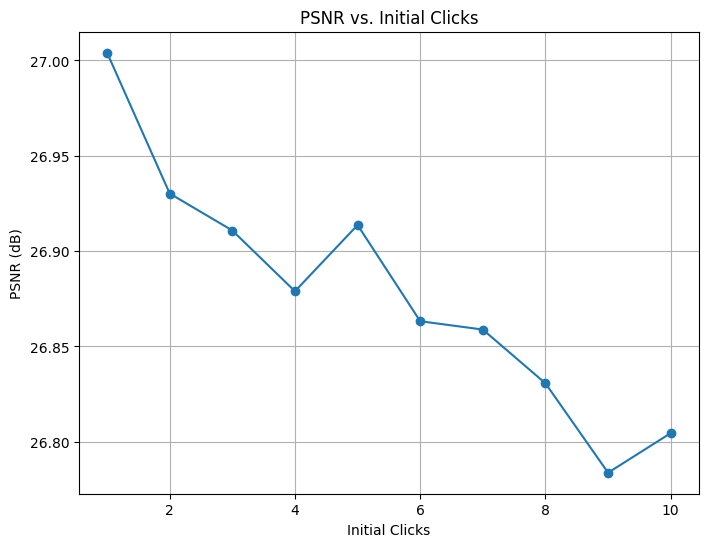


=== #Initial Clicks vs. PSNR ===
Clicks	PSNR(dB)
1	27.00
5	26.93
10	26.91


C:\Users\江睿达\AppData\Local\Temp\ipykernel_7972\4133994375.py:100: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2 negative Z values that have been clipped to zero
  rgb_pred = lab2rgb(lab_pred.clip(np.array([0, -128, -128]),
C:\Users\江睿达\AppData\Local\Temp\ipykernel_7972\4133994375.py:100: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 65 negative Z values that have been clipped to zero
  rgb_pred = lab2rgb(lab_pred.clip(np.array([0, -128, -128]),


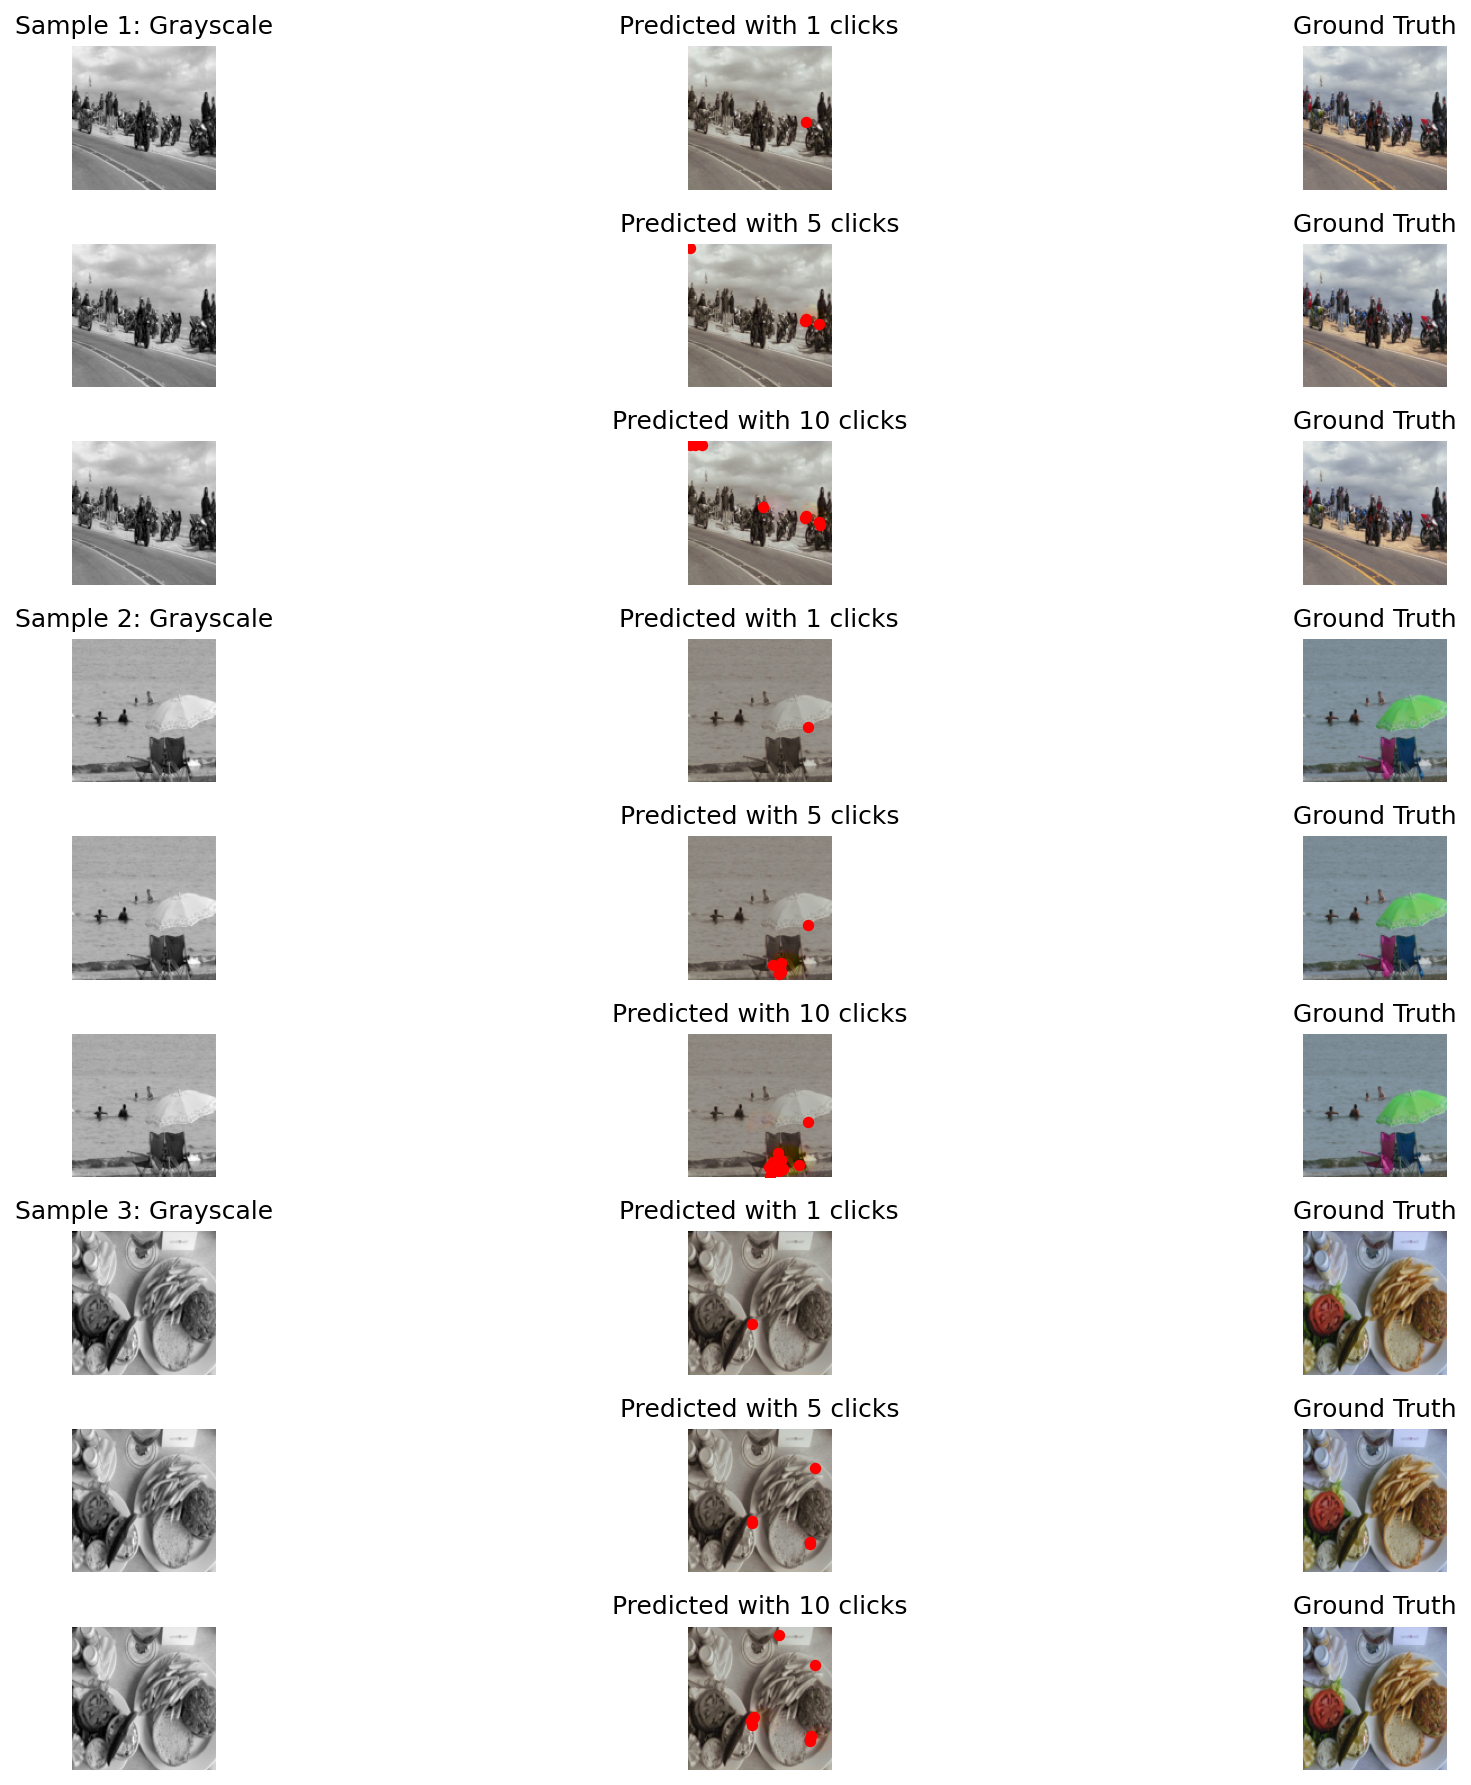

In [14]:
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    lr = 1e-4

    batch_size = 2
    num_epochs = 2
    image_size = 128
    num_iterations = 10
    initial_clicks = 1

    colornet = UNetColorNet(in_channels=4, out_channels=2).to(device)
    editnet = EditNet(in_channels=5, out_channels=1).to(device)
    optimizer = optim.Adam(list(colornet.parameters()) + list(editnet.parameters()), lr=lr)

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    criterion = nn.MSELoss()

    train_dataset = CocoColorizationDataset(root_dir="data/coco/train2017", transform_size=image_size, limit=1000)
    dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
    test_dataset = CocoColorizationDataset(root_dir="data/coco/val2017", transform_size=image_size, limit=500)
    print(f"Found {len(test_dataset)} images in validation set")
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0, pin_memory=True)

    best_psnr = -float('inf')
    for epoch in range(num_epochs):
        epoch_loss = train_one_epoch(colornet, editnet, dataloader, optimizer,
                                                      device, criterion, num_iterations, initial_clicks)

        scheduler.step()
        # scheduler_C.step()
        # scheduler_E.step()
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}")
        current_psnr = evaluate_psnr_iterative(colornet, editnet, test_loader, device,
                                               criterion, num_iterations=num_iterations,
                                               initial_clicks=initial_clicks)
        print(f"Validation PSNR: {current_psnr:.2f} dB")
        if current_psnr > best_psnr:
            best_psnr = current_psnr
            torch.save({'colornet': colornet.state_dict(),
                        'editnet': editnet.state_dict()}, "best_models.pth")
            print("Saved best models!")
    print("Training finished!")

    clicks_list = [1, 5, 10]
    _list = list(range(1, 11))
    psnr_values = []
    for n_clicks in _list:
        avg_psnr = evaluate_psnr_iterative(colornet, editnet, test_loader, device, criterion,
                                           num_iterations=num_iterations, initial_clicks=n_clicks)
        psnr_values.append(avg_psnr)
        print(f"Initial Clicks = {n_clicks} | Avg PSNR = {avg_psnr:.2f} dB")
    plt.figure(figsize=(8, 6))
    plt.plot(_list, psnr_values, marker='o', linestyle='-')
    plt.xlabel("Initial Clicks")
    plt.ylabel("PSNR (dB)")
    plt.title("PSNR vs. Initial Clicks")
    plt.grid(True)
    plt.show()
    
    print("\n=== #Initial Clicks vs. PSNR ===")
    print("Clicks\tPSNR(dB)")
    for i in range(len(clicks_list)):
        print(f"{clicks_list[i]}\t{psnr_values[i]:.2f}")
        
    visualize_results(colornet, editnet, dataset=test_dataset, device=device,
                  n_samples=3, clicks_list=clicks_list, max_clicks=10)

if __name__ == '__main__':
    main()